<a href="https://colab.research.google.com/github/LorenzoPeracchio/Reliability/blob/main/ALS_ReliabilityPaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
ROOT_PATH = '/content/drive'
drive.mount(ROOT_PATH, force_remount=True)

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth

Mounted at /content/drive


In [2]:
from google.colab import files, data_table
data_table.disable_dataframe_formatter()
import numpy as np
from itertools import combinations
import pandas as pd
import io
import time
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, f1_score, balanced_accuracy_score

import warnings
# still have to fix this (the warning is just annoying but does not affect the pipeline in any way)
warnings.filterwarnings("ignore", message="X does not have valid feature names, but LogisticRegression was fitted with feature names")
warnings.filterwarnings("ignore", message="X does not have valid feature names, but RandomForestClassifier was fitted with feature names")
warnings.filterwarnings("ignore", message="X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names")
warnings.filterwarnings("ignore", message="X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names")
warnings.filterwarnings("ignore", message="X does not have valid feature names, but MLPClassifier was fitted with feature names")

In [3]:
subtask = "C"
df_train_static = pd.read_csv(f"...train-static-vars.csv")
df_train_visits = pd.read_csv(f"...train-visits.csv")
df_train_outcome = pd.read_csv(f"...train-outcome.csv")

df_test_static = pd.read_csv(f"..._test-static-vars.csv")
df_test_visits = pd.read_csv(f"..._test-visits.csv")
df_test_outcome = pd.read_csv(f"..._test-outcome.csv")

In [4]:
## VISITS

#TRAIN

df_visits_flat = pd.DataFrame(data=None, columns=df_train_visits.columns)

for id in tqdm(np.unique(df_train_visits["id"])):
  filtered_df = df_train_visits.query(f"id=='{id}'")
  row_alfrsr = df_train_visits.iloc[filtered_df['date_alsfrs_r'].idxmax()]
  if not filtered_df['date_spiro'].isnull().all():
    row_spiro = df_train_visits.iloc[filtered_df['date_spiro'].idxmax()]
    row_merged = row_alfrsr.combine_first(row_spiro)
  else:
    row_merged = row_alfrsr
  df_visits_flat.loc[len(df_visits_flat)] = row_merged

df_train = pd.merge(df_train_static, df_visits_flat, left_on = "id", right_on = "id")
print("\nTraining\n")
display(df_train)

#TEST

df_visits_flat = pd.DataFrame(data=None, columns=df_test_visits.columns)

for id in tqdm(np.unique(df_test_visits["id"])):
  filtered_df = df_test_visits.query(f"id=='{id}'")
  row_alfrsr = df_test_visits.iloc[filtered_df['date_alsfrs_r'].idxmax()]
  if not filtered_df['date_spiro'].isnull().all():
    row_spiro = df_test_visits.iloc[filtered_df['date_spiro'].idxmax()]
    row_merged = row_alfrsr.combine_first(row_spiro)
  else:
    row_merged = row_alfrsr
  df_visits_flat.loc[len(df_visits_flat)] = row_merged

df_test = pd.merge(df_test_static, df_visits_flat, left_on = "id", right_on = "id")
print("\nTest\n")
display(df_test)

df_train_ids = df_train["id"]
df_test_ids = df_test["id"]

100%|██████████| 1756/1756 [00:11<00:00, 151.82it/s]



Training



,id,onsetDate,diagnosisDate,alive,sex,ethnicity,height,weight_before_onset,weight,moreThan10PercentWeightloss,...,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12
0,0x1002e146b2dbd9369a0e4cb3942890ad,-5.866667,1.266667,False,Female,Caucasian,1.54,59.0,57.0,False,...,4.0,4.0,4.0,3.0,3.0,3.0,2.0,4.0,4.0,4.0
1,0x1017f8696f08013e167f6682bd6481ba,-22.766667,-0.466667,False,Female,Caucasian,1.60,65.0,60.0,False,...,2.0,4.0,4.0,4.0,4.0,3.0,1.0,4.0,4.0,4.0
2,0x102e923a203f7ff00a4947a94f60da9,-9.933333,-0.800000,False,Female,Caucasian,1.52,60.0,48.0,True,...,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,3.0,4.0
3,0x1031925c2c7f35a70388b0a19f142dac,-51.500000,-33.266667,False,Male,Caucasian,NaN,NaN,NaN,NaN,...,2.0,2.0,2.0,1.0,1.0,1.0,0.0,2.0,2.0,4.0
4,0x106cc843352505bcd82305a6230c6bb5,-14.733333,0.433333,False,Female,Caucasian,1.48,58.0,58.0,False,...,4.0,2.0,1.0,1.0,1.0,1.0,0.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751,0xc9d67e94a33e95dd16ad9ac7ac4dfd5c,-11.166667,0.000000,True,Male,Black_African,1.75,82.0,41.0,True,...,4.0,1.0,1.0,0.0,2.0,4.0,3.0,3.0,4.0,4.0
1752,0xc9f26ac07e3f0a0f9aba7ad0332b7d2e,-16.966667,-0.733333,False,Female,Caucasian,1.50,67.0,50.0,True,...,0.0,3.0,3.0,3.0,2.0,2.0,0.0,3.0,3.0,4.0
1753,0xc9fd066b8a1dacfc671d6db990a1574,-12.233333,-2.033333,True,Female,Caucasian,1.70,68.0,68.0,False,...,4.0,2.0,1.0,1.0,3.0,3.0,3.0,4.0,4.0,4.0
1754,0xca11f6c22eae774554db48e9098e61a6,-46.700000,-41.600000,False,Male,Caucasian,1.70,95.0,95.0,False,...,4.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,4.0,4.0


100%|██████████| 494/494 [00:03<00:00, 136.83it/s]


Test



,id,onsetDate,diagnosisDate,alive,sex,ethnicity,height,weight_before_onset,weight,moreThan10PercentWeightloss,...,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12
0,0xca23e24556475bbc742f37df9b4dacfc,-8.400000,-2.366667,False,Male,Caucasian,1.64,84.0,84.0,False,...,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0
1,0xca2a048cc828f5ebd2000a554301d13f,-17.100000,-0.866667,False,Male,Caucasian,1.78,86.0,81.0,False,...,4.0,4.0,4.0,4.0,2.0,3.0,1.0,4.0,4.0,4.0
2,0xca4775cc1195fd2a25426c36a4a1f85c,-12.166667,0.000000,False,Female,Caucasian,1.58,47.0,42.0,True,...,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,0xca4c63706241452e87804f29621c5f01,-66.800000,-0.866667,True,Female,Caucasian,1.65,65.0,65.0,False,...,4.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0
4,0xca4d387aa324dd98b0a004cf51cc470f,-13.033333,-0.866667,True,Female,Caucasian,1.52,55.0,55.0,False,...,3.0,3.0,2.0,1.0,2.0,2.0,1.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,0xff9195ae018b73c7b70024c9dbf7c8d8,-4.566667,-1.500000,False,Female,Caucasian,1.64,65.5,65.5,False,...,2.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,4.0,4.0
490,0xffa9b0a3542580ba135d03f977b3e739,-22.866667,-2.533333,False,Male,Caucasian,1.56,66.0,66.0,False,...,3.0,3.0,4.0,3.0,4.0,2.0,1.0,3.0,4.0,4.0
491,0xffb2d295bf7d88afcf7738b39ff9503d,-8.700000,-0.566667,False,Male,Black_African,1.77,55.0,55.0,False,...,3.0,3.0,2.0,1.0,1.0,2.0,3.0,2.0,4.0,4.0
492,0xffea07026ee4819bc346649ddad2d740,-38.833333,0.733333,False,Male,Caucasian,1.68,75.0,62.0,True,...,4.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0


In [5]:
#Combine the Training and Test sets

df_raw = pd.concat([df_train, df_test])
df_raw_outcome = pd.concat([df_train_outcome, df_test_outcome])

# Removal of features containing more than 90% of NaN
original_shape = df_raw.shape
print("DataFrame shape before NaN removal:", original_shape)
df = df_raw.dropna(axis=1)
print("DataFrame shape before NaN removal:", df.shape)

# NaN removal by removing rows with at least one NaN value
# Check for NaN values
if df.isnull().any().any():  # If there's at least one column with NaN, the output is "True"
    old_row_size = original_shape[0]
    df = df.dropna(axis=0, how='any')
    print("DataFrame shape after NaN removal:", df.shape)
    new_row_size = df.shape[0]
    print("Relative percentage of removed rows (wrt the old row size): %.2f" % (
            (old_row_size - new_row_size) / old_row_size * 100))

print("Is there any NaN after NaN removal?", df.isnull().any().any())
df = pd.merge(df, df_raw_outcome, left_on = "id", right_on = "PatientID")
df = df.drop(columns=["PatientID"]) # drop the ids
df = df.drop(columns=["Type","Time"]) # we have 3 outcomes (Occured, Type, Time), keep only one (in subtask C, Type==Occured)

print("Factorizing string types...")
string_cols = np.where(df.dtypes=="object")[0]
for string_col in string_cols:
  if string_col==0:
    continue
  df.iloc[:,string_col], mapping = pd.factorize(df.iloc[:,string_col])
  print(mapping)


DataFrame shape before NaN removal: (2250, 114)
DataFrame shape before NaN removal: (2250, 29)
Is there any NaN after NaN removal? False
Factorizing string types...
Index(['Female', 'Male'], dtype='object')
Index(['Caucasian', 'Asian_ethnic_group', 'Black_African'], dtype='object')
Float64Index([               4.0,                4.4, 3.2666666666666666,
              1.5333333333333334,  4.433333333333334,  4.033333333333333,
                             0.0,  4.366666666666666,                2.7,
               5.433333333333334,
              ...
              1.9666666666666663, 0.6333333333333333, 0.9666666666666668,
                             2.2,                2.6,                1.3,
              1.7666666666666666,                1.5,                0.7,
              0.3333333333333333],
             dtype='float64', length=155)
Float64Index([43.0, 38.0, 30.0, 22.0, 44.0, 31.0, 42.0, 41.0, 45.0, 39.0, 13.0,
              40.0, 46.0, 32.0, 34.0, 16.0, 19.0, 33.0, 35.0, 26

In [6]:
#PROBLEM: alive==False *always* implies Occured==1, alive==Ture *almost always* implies Occured==0 --> No complexity, decision trees will always be IF dead THEN death ELSE none
display(pd.crosstab(df["alive"],df["Occured"]))
df = df.drop(columns=['alive'])

Occured,0,1
alive,,
False,0,1852
True,347,51


In [7]:
#DATA PREPARATION
pred_col = 'Occured' #edit this line when using another dataset

X = df.drop(columns=['id'])
y = X[pred_col]
X_feat = X.drop(columns=[pred_col])
feature_names = X_feat.columns

#check which features has less than 10 unique values to identify a subset of probable categorical features
print(feature_names[np.where([len(np.unique(X_feat.iloc[:,i]))<10 for i in range(X_feat.shape[1])])])
categorical_feat = ['sex', 'ethnicity'] # edit this line when using another dataset
iscat = [x in categorical_feat for x in feature_names]


#split the data based on the ethnicity feature: samples with ethnicity=0 are In-Distribution (ID) (Training and Validation sets), while samples with ethnicity≠0 are OOD (X_out set)
X_in = df.loc[df['ethnicity']==0]
X_out = df.loc[df['ethnicity']!=0]
y_in = X_in[pred_col]
y_out = X_out[pred_col]
X_in = X_in.drop(columns=['id',pred_col])
X_out = X_out.drop(columns=['id',pred_col])

# Train val split
X_train, X_val, y_train, y_val = train_test_split(X_in, y_in, test_size = 0.3, random_state = 42, stratify=y_in, shuffle=True)

# scaling
scaler = MinMaxScaler()
cols = X_train.columns[X_train.columns != 'ethnicity']
X_train[cols] = scaler.fit_transform(X_train[cols])
X_val[cols] = scaler.fit_transform(X_val[cols])
X_out[cols] = scaler.fit_transform(X_out[cols])

# Numpy version
X_train_nd = X_train.to_numpy(dtype=float)
X_val_nd = X_val.to_numpy(dtype=float)
X_out_nd = X_out.to_numpy(dtype=float)
y_train_nd = y_train.to_numpy(dtype=int)
y_val_nd = y_val.to_numpy(dtype=int)
y_out_nd = y_out.to_numpy(dtype=int)



Index(['sex', 'ethnicity', 'onset_bulbar', 'onset_axial', 'onset_generalized',
       'onset_limbs', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9',
       'q10', 'q11', 'q12'],
      dtype='object')


In [8]:
# ethnicity counter for training, validation and out set
from collections import Counter
print("X_train:", Counter(X_train['ethnicity']))
print("X_val:", Counter(X_val['ethnicity']))
print("X_out:", Counter(X_out['ethnicity']))

X_train: Counter({0: 1564})
X_val: Counter({0: 671})
X_out: Counter({2: 12, 1: 3})


In [9]:
#CLASSIFIERS
import collections

def get_best_threshold_f1(X,y,y_pred):
  prec, recall, threshold = precision_recall_curve(y, y_pred, pos_label=0)
  f1 = 2*prec*recall/(prec+recall)
  return(0.5)
  #return(threshold[np.where(f1==np.nanmax(f1))])

print("True Labels")
print(collections.Counter(y_val))
print()

#Gradient Boosting
clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=1, random_state=0).fit(X_train, y_train)
ypred_proba = clf_gb.predict_proba(X_val)[:,1]
sel_thr_gb = get_best_threshold_f1(X_val,y_val,ypred_proba)
ypred_gb = (clf_gb.predict_proba(X_val)[:,1] >= sel_thr_gb).astype(int)

print("Gradient Boosting")
print(collections.Counter(ypred_gb))
print(f"F1: {f1_score(y_val, ypred_gb, pos_label=0)}")
print(f"BAL_ACC: {balanced_accuracy_score(y_val, ypred_gb)}\n")

#Random Forest
clf_rf = RandomForestClassifier(random_state=1).fit(X_train, y_train)
ypred_proba = clf_rf.predict_proba(X_val)[:,1]
sel_thr_rf = get_best_threshold_f1(X_val,y_val,ypred_proba)
ypred_rf = (clf_rf.predict_proba(X_val)[:,1] >= sel_thr_rf).astype(int)

print("Random Forest")
print(collections.Counter(ypred_rf))
print(f"F1: {f1_score(y_val, ypred_rf, pos_label=0)}")
print(f"BAL_ACC: {balanced_accuracy_score(y_val, ypred_rf)}\n")

#Logistic Regression
clf_lr = LogisticRegression(random_state=1, penalty='l1', solver='liblinear').fit(X_train, y_train)
ypred_proba = clf_lr.predict_proba(X_val)[:,1]
sel_thr_lr = get_best_threshold_f1(X_val,y_val,ypred_proba)
ypred_lr = (clf_lr.predict_proba(X_val)[:,1] >= sel_thr_lr).astype(int)
ypred_lr_train = (clf_lr.predict_proba(X_train)[:,1] >= sel_thr_lr).astype(int)

print("Logistic Regression")
print(collections.Counter(ypred_lr))
print(f"F1: {f1_score(y_val, ypred_lr, pos_label=0)}")
print(f"BAL_ACC: {balanced_accuracy_score(y_val, ypred_lr)}\n")
print(f"BAL_ACC training: {balanced_accuracy_score(y_train, ypred_lr_train)}\n")

#Multi-layer perceptron (neural network)
clf_nn = MLPClassifier(random_state=1, max_iter=500).fit(X_train, y_train)
ypred_proba = clf_nn.predict_proba(X_val)[:,1]
sel_thr_nn = get_best_threshold_f1(X_val,y_val,ypred_proba)
ypred_nn = (clf_nn.predict_proba(X_val)[:,1] >= sel_thr_nn).astype(int)

print("Multi-layer Perceptron")
print(collections.Counter(ypred_nn))
print(f"F1: {f1_score(y_val, ypred_nn, pos_label=0)}")
print(f"BAL_ACC: {balanced_accuracy_score(y_val, ypred_nn)}\n")

classifier_dict = {'GB': clf_gb, 'RF': clf_rf, 'LR': clf_lr, 'NN': clf_nn}
classifier_thr = {'GB': sel_thr_gb, 'RF': sel_thr_rf, 'LR': sel_thr_lr, 'NN': sel_thr_nn}

print(classifier_thr)

True Labels
Counter({1: 569, 0: 102})



<ipython-input-9-6109184a966f>:6: RuntimeWarning: invalid value encountered in divide
  f1 = 2*prec*recall/(prec+recall)


Gradient Boosting
Counter({1: 665, 0: 6})
F1: 0.037037037037037035
BAL_ACC: 0.506288983080051

Random Forest
Counter({1: 670, 0: 1})
F1: 0.01941747572815534
BAL_ACC: 0.5049019607843137

Logistic Regression
Counter({1: 671})
F1: 0.0
BAL_ACC: 0.5

BAL_ACC training: 0.5093729799612152



<ipython-input-9-6109184a966f>:6: RuntimeWarning: invalid value encountered in divide
  f1 = 2*prec*recall/(prec+recall)


Multi-layer Perceptron
Counter({1: 623, 0: 48})
F1: 0.10666666666666666
BAL_ACC: 0.5040663013887453

{'GB': 0.5, 'RF': 0.5, 'LR': 0.5, 'NN': 0.5}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
<ipython-input-9-6109184a966f>:6: RuntimeWarning: invalid value encountered in divide
  f1 = 2*prec*recall/(prec+recall)


RELIABILITY

In [10]:
!python -m pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple ReliabilityPackage --upgrade

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple


In [11]:
from ReliabilityPackage.ReliabilityFunctions import *

In [12]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import plotly.offline as pyo

Build an Autoencoder on the Training set

EPOCH 1
EPOCH 2
EPOCH 3
...
...
...
EPOCH 997
EPOCH 998
EPOCH 999
EPOCH 1000


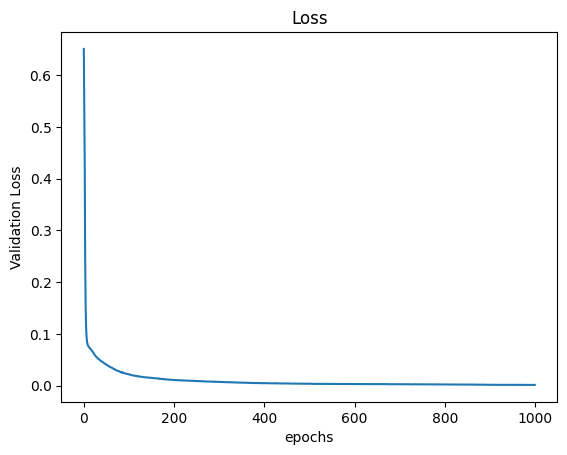

In [13]:
ae = create_and_train_autoencoder(X_train_nd, X_val_nd, batchsize=80, epochs=1000)

In [14]:
print("Training set avg MSE:", compute_dataset_avg_mse(ae, X_train_nd))
print("Validation set avg MSE:", compute_dataset_avg_mse(ae, X_val_nd))
print("OOD set avg MSE:", compute_dataset_avg_mse(ae, X_out_nd))

Training set avg MSE: 0.000996365058943946
Validation set avg MSE: 0.0015593726238216567
OOD set avg MSE: 0.13764589623391063


Generate the Dataset of the synthetic points and compute their associated accuracies

In [15]:
syn_pts, acc_syn_pts = generate_synthetic_points("classification", clf_lr.predict, X_train_nd, y_train_nd, method="GN", k = 5)

Define a MSE threshold and an Accuracy threshold

In [19]:
mse_thresh = perc_mse_threshold(ae, X_val_nd, perc=98)
acc_thresh = 0.50

Generate an instance of the Reliability Detector Class (class-object able to evaluate the pointwise reliability of instances)

In [20]:
RD = create_reliability_detector("classification", ae, syn_pts, acc_syn_pts, mse_thresh=mse_thresh, perf_thresh=acc_thresh, proxy_model="MLP")

Evaluate the reliability of the Training, Validation, and Out sets

In [21]:
out_reliability= compute_dataset_reliability(RD, X_out_nd, mode='density')
reliable_out = X_out_nd[np.where(out_reliability == 1)]
y_reliable_out = y_out_nd[np.where(out_reliability == 1)]
unreliable_out = X_out_nd[np.where(out_reliability == 0)]
y_unreliable_out = y_out_nd[np.where(out_reliability == 0)]

X_train_reliability= compute_dataset_reliability(RD, X_train_nd, mode='density')
reliable_train = X_train_nd[np.where(X_train_reliability == 1)]
unreliable_train = X_train_nd[np.where(X_train_reliability == 0)]

X_val_reliability= compute_dataset_reliability(RD, X_val_nd, mode='density')
reliable_val = X_val_nd[np.where(X_val_reliability == 1)]
unreliable_val = X_val_nd[np.where(X_val_reliability == 0)]

print("X_train:", Counter(X_train_reliability))
print("X_val:", Counter(X_val_reliability))
print("X_out:", Counter(out_reliability))

X_train: Counter({1: 1547, 0: 17})
X_val: Counter({1: 657, 0: 14})
X_out: Counter({0: 15})
